In [1]:
import numpy as np

##################################################
##### Matplotlib boilerplate for consistency #####
##################################################
from ipywidgets import interact
from ipywidgets import FloatSlider, IntSlider
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

global_fig_width = 8
global_fig_height = global_fig_width / 1.61803399
font_size = 12

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.edgecolor'] = '0.8'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelpad'] = 8
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlepad'] = 16.0
plt.rcParams['axes.titlesize'] = font_size * 1.4
plt.rcParams['figure.figsize'] = (global_fig_width, global_fig_height)
plt.rcParams['font.sans-serif'] = ['Computer Modern Sans Serif', 'DejaVu Sans', 'sans-serif']
plt.rcParams['font.size'] = font_size
plt.rcParams['grid.color'] = '0.8'
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['lines.dash_capstyle'] = 'round'
plt.rcParams['lines.dashed_pattern'] = [1, 4]
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['xtick.major.pad'] = 4
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['ytick.major.pad'] = 4
plt.rcParams['ytick.major.size'] = 0
##################################################

# Course Structure

- Lecture 1: Introduction to Bayesian Inference and Pints
- Lecture 2: Maximum Likelihood Estimation
- **Lecture 3: MCMC sampling**
    - **Independent Sampling**
    - **Dependent Sampling - Markov Chain Monte Carlo**
    - **Random Walk Metropolis**
    - **Convergence**
    - **Effective Sample Size**
- Lecture 4: Hierarchical models

## Generating independent samples:

**Question:** how can we generate independent samples from the following (un-normalised) PDF?

In [2]:
from scipy.stats import norm
def P(x):
    return 0.2*norm.pdf(x,0.4,0.2) + 0.4*norm.pdf(x,1,0.2)+ 0.3*norm.pdf(x,1.6,0.1)

In [3]:
def show_pdf():
    x = np.linspace(0,2,100)
    y = P(x)
    plt.plot(x,y)
    plt.fill_between(x,y,alpha=0.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$P(x)$')
    plt.show()

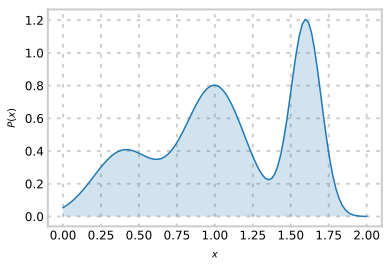

In [4]:
show_pdf()

**Answer:** do the following a large number of times:
1. Generate $x$ coordinates: uniformly-distributed points from $(0, 2)$; where $2$ is the domain of the function.
2. Generate $y$ coordinates: uniformly-distributed points from $(0, 1)$; where 1 is the maximum value of the function.
3. If $y < P(x)$, then accept $x$ coordinate as a sample.
4. If $y \ge P(x)$, then reject $x$ coordinate as a sample.
Known as **Rejection** sampling.

In [5]:
N = 100000
x = np.random.uniform(0,2,N)
y = np.random.uniform(0,1,N)
x_samples = x[y < P(x)]

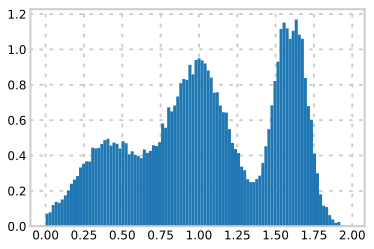

In [6]:
plt.hist(x_samples,bins=100,density=True)
plt.show()

## Why do sampling in the first place?

Samples from the posterior:

$$P(\theta | data) = \frac{P(data|\theta) P(\theta)}{P(data)}$$

- Shows the likely *distribution* of parameters, rather than single most likely point. Shows:
 - Correlated parameters
 - Unidentifiable parameters
 - Credible intervals

## Why do sampling in the first place?

- Often, want to calculate the posterior mean of some parameter, $\theta_1$:
    
$$
E(\theta_1|X) = \int_{\theta_1} \int_{\theta_{-1}} 
\theta_1  P(\theta_1, \theta_{-1} | X)d \theta_{-1} d \theta_1
$$

where $\theta_{-1}$ corresponds to the $d − 1$ other parameters of the
model.

- Posterior mean can be approximated by summing over posterior samples

- Marginal distributions can also be obtained from posterior samples:

$$
P(\theta_1|X) = \int_{\theta_{-1}} P(\theta_1, \theta_{-1} | X)d \theta_{-1}
$$

## Why is generating independent samples difficult?

- **Rejection sampling** requires generation of a large number
of random points to produce relatively few samples.
- This inefficiency increases (exponentially) with the
dimensionality of the distribution; i.e. for posteriors with
more parameters.
- Other methods exist (inverse-transform sampling and
importance sampling, for example) but they suffer from
complexity and/or inefficiency issues.
- We cannot calculate the denominator so are unable to use
some of these methods.
- Even if we had the denominator the complexity of most
models means that independent sampling isn’t possible.

## Is sampling finished?

<center>
<img src="fig/sad-clown.jpg"> 
</center>

## What is dependent sampling?

- A sampling algorithm where the next sample depends on the current value, and the list of all (accepted) positions of the
sampler form the sample.

**Example dependent sampler:** 

1. choose a new position based on a local “jumping” distribution.
2. Suppose the next value of the sampler is drawn from a 2d normal distribution centred on our current position.

## Dependent samplers as Markov Chains (Monte Carlo)

- Where to step next is determined via a distribution
conditional on the current parameter value.
- This stepping is probabilistic $\rightarrow$ *Monte Carlo*.
- The conditional distribution only depends on the current
value of the sampler meaning it is memoryless about past
path.
- This memoryless means that the path of the sampler is a
*1st order Markov Chain*.

## Open questions

How can we decide on the:
1. Starting position.
2. Jumping distribution’s shape.
3. Acceptance criteria

To ensure convergence to the posterior distribution? Especially
because we cannot compute the posterior itself!

# Random Walk Metropolis

A discrete example: **David Robinson’s fishing**
    
- David Robinson (a more fortunate cousin of Robinson
Crusoe) is marooned on an island.
- Access to four freshwater lakes of different sizes; each with
a supply of fish.

<center>
<img src="fig/david_robinson.svg"> 
</center>

## David Robinson’s fishing

- He has a terrible memory (too much coconut toddy), and
each day forgets any estimates of lake size he made
previously.
- He wants to fish (at maximum) one new lake per day.
- He possesses a coin and a solar-powered calculator that
can generate (pseudo-)random numbers uniformly
distributed between 0 and 1.
- He is initially “washed up” next to lake A.

<center>
<img src="fig/david_robinson.svg"> 
</center>

**Question:** What strategy should he use to fish as
sustainably as possible?

**Remember:** Robinson doesn’t know the # of lakes, nor
the amount of fish in each!

<center>
<img src="fig/david_robinson.svg"> 
</center>

**Answer:** visit each lake in proportion to the fish it contains, by
doing the following:
1. Each night he flips the coin.
2. If it’s heads (tails) he proposes a move to the neighbouring
lake in the clockwise (anticlockwise) direction.
3. Calculates the ratio of the size of the proposed lake to the
current one.
4. Compares the ratio with a (pseudo-)random number from
the calculator.
5. If the ratio exceeds the generated number, he moves. If
not, he stays put and fishes the same lake tomorrow.

## David Robinson’s fishing: does it work?

In [7]:
N = 500
x = [0, 1, 2, 3]
lakes = [2.0, 1.0, 4.0, 2.0]
days = np.zeros((4,N))
current_lake = 0

for i in range(1,N):
    days[:,i] = days[:,i-1]
    
    # move either clockwise or counter-clockwise
    proposed_lake = current_lake + 2*int(np.random.uniform() < 0.5) - 1
    if proposed_lake > 3:
        proposed_lake = 0;
    elif proposed_lake < 0:
        proposed_lake = 3
        
    # accept move based on the ratio of lake sizes
    ratio = lakes[proposed_lake]/lakes[current_lake]
    if ratio > np.random.uniform():
        current_lake = proposed_lake
        
    days[current_lake, i] += 1

In [8]:
def plot_david_robinson(i):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8/1.618))
    ax1.plot(x, days[:,i], 'bo', ms=8, label='poisson pmf')
    ax1.vlines(x, 0, days[:,i], colors='b', lw=5, alpha=0.5)
    ax2.plot(x, lakes, 'bo', ms=8, label='poisson pmf')
    ax2.vlines(x, 0, lakes, colors='b', lw=5, alpha=0.5)
    ax1.set_ylim(0,N/2)
    plt.show()

day_widget = IntSlider(value=5, min=0, max=N-1, step=1, continuous_update=False)

In [9]:
interact(plot_david_robinson, i=day_widget, continuous_update=False);

interactive(children=(IntSlider(value=5, continuous_update=False, description='i', max=499), Output()), _dom_c…

## David Robinson’s fishing: summary

- Robinson lacked knowledge of numbers of fish in each lake and the number of lakes.
- Only knows that the number of fish in each lake is proportionate to its size.
- His memory stops him remembering the exact sizes.
- After about 100 days his “random” strategy is quite similar from an “omniscient” one.

## Defining Random Walk Metropolis

Robinson’s strategy is an example of the “Random Walk Metropolis” algorithm. This has the following form:

- Generate a random starting location $\theta_0$.
- Iterate the following for $t = 1, ..,T$:
  - Propose a new location from a jumping distribution: 
$$\theta_{t+1} \sim J(\theta_{t+1}|\theta_t)$$.
  - Calculate the ratio: 
$$r = \frac{\text{likelihood}(\theta_{t+1}) \times \text{prior}(\theta_{t+1})}{\text{likelihood}(\theta_t) \times \text{prior}(\theta_t)}$$
  - Compare $r$ with a uniformly-distributed number $u$ between 0 and 1.
  - If $r \ge u \Rightarrow$ we move.
  - Otherwise, we remain at our current position.

In [10]:
T = 2000
chain = np.empty(T,dtype=float)
theta0 = 1.0
accepted = 0
for t in range(T):
    # Propose a new location from a jumping distribution
    theta1 = np.random.normal(theta0,0.2)
    
    # Calculate the ratio
    r = P(theta1)/P(theta0)
    
    # Compare r with a uniformly-distributed number between 0 and 1.
    if r >= np.random.uniform():
        theta0 = theta1
    
    # Add to chain of samples
    chain[t] = theta0  

In [11]:
def show_mcmc_chain(chain):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8/1.618))
    ax1.plot(chain)
    ax1.set_xlabel(r'iteration $t$')
    ax1.set_ylabel(r'parameter $\theta$')
    ax2.hist(chain,bins=50,density=True)
    ax2.set_ylabel(r'probability')
    ax2.set_xlabel(r'parameter $\theta$')
    ax2.set_xlim(0,2)
    ax1.set_ylim(0,2)
    x = np.linspace(0,2,100)
    ax2.plot(x, P(x))
    plt.show()

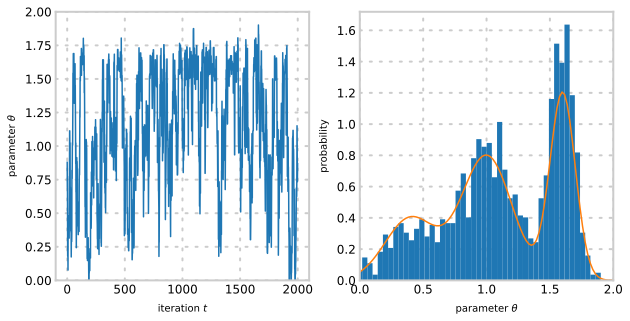

In [12]:
show_mcmc_chain(chain)

## MCMC Sampling using PINTS

- We can wrap our $P(x)$ PDF using PINTS


In [13]:
import pints
import pints.toy

class MyPDF(pints.toy.ToyLogPDF): 
    
    def __call__(self, x):
        result = P(x)
        if result == 0:
            return -np.inf
        else:
            return np.log(result)
    
    def n_parameters(self):
        return 1

log_pdf = MyPDF()

## MCMC Sampling using PINTS

- and then sample using MCMC

In [14]:
# Create an MCMC routine
x0 = [[1.0]]
mcmc = pints.MCMCController(log_pdf, 1, x0, sigma0=0.2, method=pints.MetropolisRandomWalkMCMC)

# Set maximum number of iterations
mcmc.set_max_iterations(2000)

# Run the method
chains = mcmc.run()

Using Metropolis random walk MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.0
1     2      0          0:00.0
2     3      0.333      0:00.0
3     4      0.5        0:00.0
20    21     0.762      0:00.0
40    41     0.537      0:00.0
60    61     0.574      0:00.0
80    81     0.568      0:00.0
100   101    0.564      0:00.1
120   121    0.57       0:00.1
140   141    0.589      0:00.1
160   161    0.59       0:00.1
180   181    0.608      0:00.1
200   201    0.641791   0:00.1
220   221    0.633      0:00.1
240   241    0.639      0:00.1
260   261    0.64       0:00.1
280   281    0.637      0:00.1
300   301    0.627907   0:00.1
320   321    0.632      0:00.2
340   341    0.622      0:00.2
360   361    0.615      0:00.2
380   381    0.612      0:00.2
400   401    0.613      0:00.2
420   421    0.615      0:00.2
440   441    0.61678    0:00.2
460   461    0.61       0:00.2
480   481    0.611      0:00.2
500   501    0.605

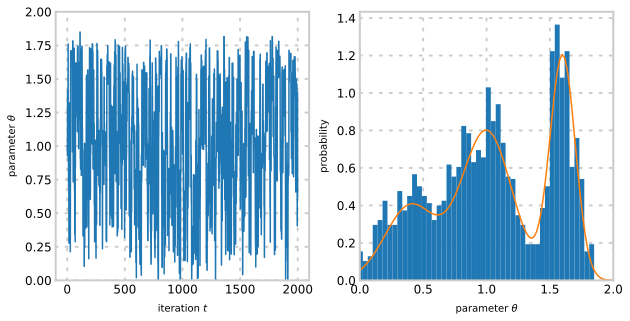

In [15]:
show_mcmc_chain(chains[0])

## Random Walk Metropolis: benefits
- Under quite general conditions the Random Walk
Metropolis sampler converges asymptotically to the
posterior.
- However for a sufficiently large sample size the sampling
distribution may be practically indistinguishable from the
true posterior.
- The algorithm requires us to be able to calculate the ratio:

$$r = \frac{\text{likelihood}(\theta_{t+1}) \times \text{prior}(\theta_{t+1})}{\text{likelihood}(\theta_t) \times \text{prior}(\theta_t)}$$

- The ratio uses only the numerator of Bayes’ rule $\Rightarrow$ we
side-step calculating the denominator!

## The importance of the accept/reject rule

- **Question:** what’s the function of the accept/reject rule
we use in the Metropolis algorithm?

- allows sampling from
each point in exact proportion to the posterior height

- Consider the ratio of the posterior density at point \theta_{t+1} to \theta_t

\begin{align*}
r &= \frac{P(\theta_{t+1}|X)}{P(\theta_t|X)} \\
  &= \frac{\frac{P(X|\theta_{t+1})P(\theta_{t+1})}{P(X)}}{\frac{P(X|\theta_t)P(\theta_t)}{P(X)}} \\
  &= \frac{P(X|\theta_{t+1})P(\theta_{t+1})}{P(X|\theta_t)P(\theta_t)}
\end{align*}

So the ratio of the numerators of Bayes’ rule is identical to the
ratio of the actual posteriors.

$\Rightarrow$ if we use r to guide our stepping we will be sampling
(eventually) from the posterior

## How do we choose the jumping distribution?

- Sometimes called the “proposal distribution”.
- In Random Walk Metropolis we use a symmetric
distribution (relaxed in Metropolis-Hastings):

$$=⇒ J(\theta_a|\theta_b) = J(\theta_b|\theta_a)$$

In [16]:
def show_proposal_distribution(sigma):
    theta_a = 1
    theta_b = theta_a+sigma
    x = np.linspace(0,3,100)
    plt.plot(x,norm.pdf(x,theta_a, sigma))
    plt.plot(x,norm.pdf(x,theta_b, sigma))
    plt.plot([theta_a,theta_b],[norm.pdf(theta_a,theta_b, sigma),norm.pdf(theta_b,theta_a, sigma)], color='k')
    plt.plot([theta_a, theta_a],[0, norm.pdf(theta_a,theta_b, sigma)], color='k', ls='--')
    plt.plot([theta_b, theta_b],[0, norm.pdf(theta_b,theta_a, sigma)], color='k', ls='--')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$J$')

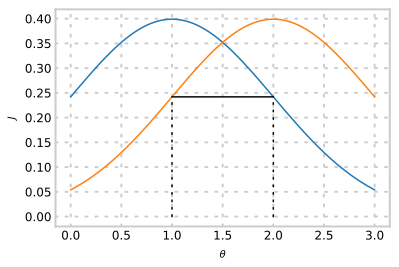

In [17]:
show_proposal_distribution(1)

## The importance of step size

**Question:** how should we decide on the jumping kernel’s step
size?

In [18]:
interact(show_proposal_distribution, sigma=FloatSlider(value=1.0, min=0, max=2.0, step=0.01), continuous_update=False);

interactive(children=(FloatSlider(value=1.0, description='sigma', max=2.0, step=0.01), Output()), _dom_classes…

In [19]:
def vary_step_size(log_sigma0, n):
    x0 = [[1.0]]
    mcmc = pints.MCMCController(log_pdf, 1, x0, sigma0=np.exp(log_sigma0), method=pints.MetropolisRandomWalkMCMC)
    mcmc.set_max_iterations(n)
    mcmc.set_log_to_screen(False)
    chains = mcmc.run();
    show_mcmc_chain(chains[0])
    
interact(vary_step_size, log_sigma0=FloatSlider(value=-1, min=-8, max=4, step=1,continuous_update=False), n=IntSlider(value=50, min=50, max=10000, step=1,continuous_update=False));

interactive(children=(FloatSlider(value=-1.0, continuous_update=False, description='log_sigma0', max=4.0, min=…

## Step size: summary
- Whilst step size does not affect asymptotic convergence, it does affect finite sample performance.
- If step size is too small we do not find the typical set (area of high probability mass).
- If step size is too large we find the typical set, but do not explore it efficiently.
- Therefore do an initial run of sampler to find optimal step size before starting proper.

## Judging convergence of chains to posterior

- What do we mean by convergence?

In [20]:
def show_convergence(n):
    x0 = [[1.0]]
    mcmc = pints.MCMCController(log_pdf, 1, x0, sigma0=0.2, method=pints.MetropolisRandomWalkMCMC)
    mcmc.set_max_iterations(n)
    mcmc.set_log_to_screen(False)
    chains = mcmc.run();
    show_mcmc_chain(chains[0])

In [21]:
interact(show_convergence, n=IntSlider(value=50, min=50, max=20000, step=1,continuous_update=False));

interactive(children=(IntSlider(value=50, continuous_update=False, description='n', max=20000, min=50), Output…

## Why do we need to monitor convergence?
- Start with an initial proposal distribution based on the jumping distribution $J$

$$\pi(\theta) \ne P(\theta|X)$$.

- Repeatedly take steps and use the Metropolis accept/reject rule: $\Rightarrow \pi(\theta_t)$; the sampling distribution at time $t$.
- Under a set of quite general assumptions we are guaranteed that asymptotically: 

$$\pi(\theta_t) \rightarrow P(\theta|X)$$.

- However, when practically can we assume: $\pi(\theta_t) \approx P(\theta|X)$?
- To monitor convergence to the posterior $\Rightarrow$ need the posterior.
- But we don’t have the posterior $\Leftarrow$ the reason we are doing the sampling in the first place!

## Two strategies for monitoring convergence

**Strategy 1:** measure distributional separation. For example Kullback-Leibler:
$$KL = \int P(\theta|X) \log \left( \frac{P(θ|X)}{\pi(\theta_t)} \right) d\theta$$.
- Motivated by information theory.
- Can use un-normalised posterior to do this.
- Again integral is too difficult to do.

**Strategy 2:** monitor the approach to a stationary distribution.
- We know asymptotically this will happen.
- By design of Metropolis stepping and accept/reject rules, we know the stationary distribution is the posterior.

## Monitoring convergence of a single chain
Initial idea:
- Compare summaries (mean, variance, etc.) of sampling distribution for a chain at time $t$ with itself at time $t + T$.
- If their rate of change is below a threshold $\Rightarrow$ convergence.

### **Question:** What is the problem with this idea?

## Convergence monitoring: Bob’s bees

Thought experiment:
- Imagine a house of unknown shape.
- We have an unlimited supply of bees, each equipped with a GPS tracker allowing us to accurately monitor their position.

**Question:** How can we use these to estimate the shape of the house?

<center>
<img src="fig/bee.svg", height="200" width="200"> 
</center>

## Convergence monitoring: Bob’s bees

**Answer:**
- Release one (at a random location in the house) and monitor its path over time.
- Stop/collect bee after summary measures of its path stop changing

In [22]:
from scipy.stats import multivariate_normal
class BobsHousePDF(pints.toy.ToyLogPDF): 
    def __call__(self, x):
        result = multivariate_normal.pdf(x,[0.25,0.25], 0.01) \
               + multivariate_normal.pdf(x,[0.75,0.25], 0.01) \
               + multivariate_normal.pdf(x,[0.75,0.75], 0.01)
        if result > 1.35:
            return 0
        else:
            return -np.inf
    
    def n_parameters(self):
        return 2

def bobs_bees(n):
    pdf = BobsHousePDF()
    x0 = []
    for i in range(n):
        accept = False
        while not accept:
            pt = [np.random.uniform(), np.random.uniform()]
            accept = pdf(pt) == 0
        x0.append(pt)
    sigma0 = [0.001, 0.001]
    mcmc = pints.MCMCController(pdf, n, x0, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)
    mcmc.set_max_iterations(1000)
    mcmc.set_log_to_screen(False)
    chains = mcmc.run();
    
    for chain in chains:
        plt.plot(chain[:,0],chain[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()
    

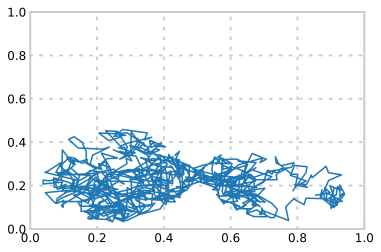

In [23]:
bobs_bees(1)

### **Question:** what’s the actual shape of the house?

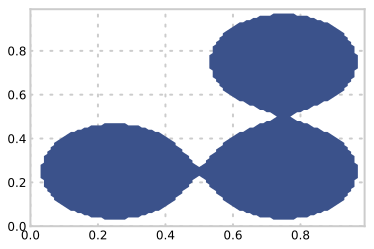

In [24]:
x, y = np.mgrid[0:1:.01, 0:1:.01]
result = np.empty(x.shape)
pdf =  BobsHousePDF()
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        result[i,j] = pdf([x[i,j],y[i,j]])

plt.contourf(x, y, result)
plt.show()

## Single chain problems: summary
- One way to monitor convergence is to look for convergence in a single chain’s summary statistics.
- This method is very susceptible to the curse of hindsight problem (“Now we’ve definitely converged on the posterior. We hadn’t a minute ago.”)
- Particularly because chains often get stuck in subregions of $\theta$ space.


## The solutions: lots of bees

- Release lots of bees starting at dispersed locations in parameter space.
- Stop recording when an individual bee’s path is indistinguishable from all others’.


<img src="fig/bee.svg" style="float: left; width: 15%;">
<img src="fig/bee.svg" style="float: left; width: 15%;">
<img src="fig/bee.svg" style="float: left; width: 15%;">
<img src="fig/bee.svg" style="float: left; width: 15%;">
<img src="fig/bee.svg" style="float: left; width: 15%;">
<p style="clear: both;">

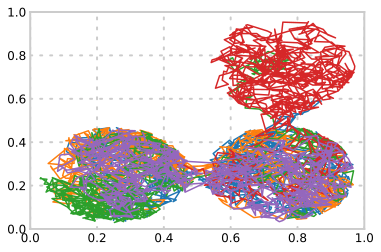

In [25]:
bobs_bees(5)

## Multiple chain convergence monitoring: summary
    
- Start a number of chains in random dispersed locations in $\theta$ space.
- Chains do *not* interact with one another (in Metropolis).
- Run each sampler until it is hard to distinguish one chain’s path from all others’.
- Less susceptible to “curse of hindsight”, since we can see if chains aren’t mixing.
- Not foolproof! There still may be an area of high probability mass that we miss. However, less likely to fail compared to a single chain.
- The more chains, the better!

## Multiple chain convergence monitoring: open questions
1. How to determine “random dispersed locations” at which to start the chains?
 - Ideally use an initial proposal distribution similar to posterior shape. 
 - Otherwise a good rule of thumb is “Any point you don’t mind having in a sample is a good starting point”, Charles Geyer.
2. Which summary statistics to monitor to determine convergence? 
3. At what threshold are “between chain” statistics sufficiently similar?

## Gelman and Rubin’s $\hat{R}$

- Gelman and Rubin (1992) had the idea of comparing within-chain to between-chain variability.
- They quantified this comparison using:

$$ \hat{R} = \sqrt{\frac{W + \frac{1}{n} (B − W)} {W}}$$,


- where “within-chain” variability,  $W = \frac{1}{m} \sum_{j=1}^m s_j^2\text{, for }m\text{ chains}$.

- and “between-chain” variability,  $B = \frac{n}{m-1}\sum_{j=1}^{m} \bar{\theta}_j - \bar{\theta})^2$.

- When we start $B >> W$ since we start in an overdispersed position.
- In convergence $B \rightarrow W \Rightarrow \hat{R} \rightarrow 1$ (in practice $\hat{R} < 1.1$ usually suffices).

## Warm up period

- The initial proposal distribution is not the posterior.
- We therefore discard the beginning part of the chain called the “warm up” to lessen the effect of the starting position.
- Typically discard first half of converged chains (can also cut chains in two to monitor intra-chain convergence).

<img src="fig/Man_Doing_Warm_Up_Exercise_Cartoon.svg" style="width: 30%;">


## Complete example: Logistic model

- Lets look at a complete example of using Metropolis MCMC on a time-series model
- We will use the Logistic equation,

$$ \frac{dy(t)}{dt} = r y(t) \frac{k - y(t)}{k}$$

- parameters are $\boldsymbol{\theta} = [r, k]$

In [26]:
import pints
import pints.toy
# Load a forward model
model = pints.toy.LogisticModel()

## Generate some data

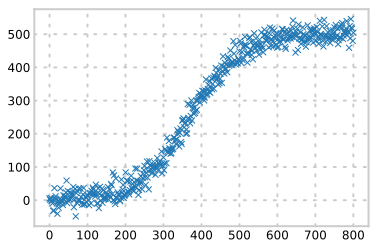

In [27]:
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 800, 500)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 20
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.figure()
plt.plot(times, values, 'x')
plt.show()

## Setup the problem in PINTS

Need to create:
1. problem $\Rightarrow$ likelihood
3. prior
4. likelihood + prior $\Rightarrow$ posterior

In [28]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

## Setup MCMC algorithm

Need to choose:
1. Number of chains
2. Starting points
3. Step size

In [29]:
# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Choose a covariance matrix for the proposal step
sigma0 = np.abs(real_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

## Sample from posterior using MCMC

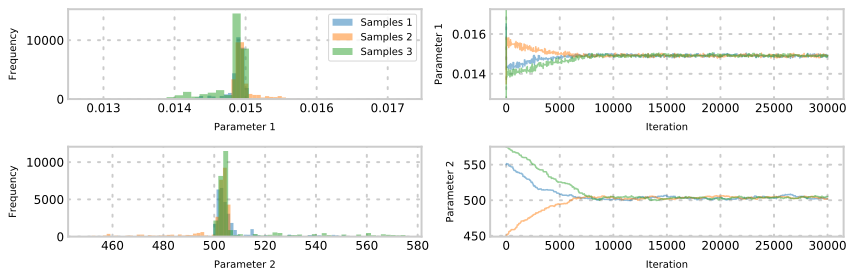

In [30]:
# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
chains = mcmc.run()

# Show traces and histograms
import pints.plot
pints.plot.trace(chains)
plt.show()

## Discard warm up and check R-hat:

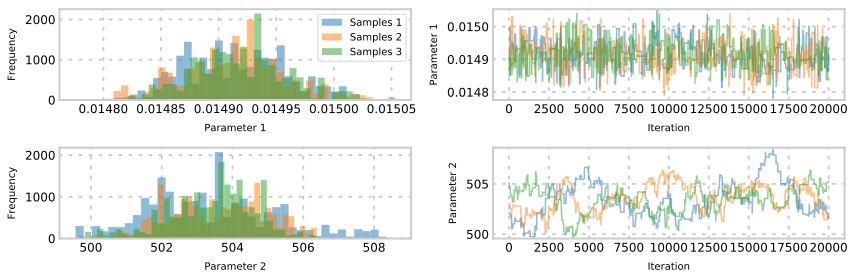

R-hat:
[1.0029215121392403, 1.0025197451038441]


In [31]:
# Discard warm up
chains = chains[:, 10000:, :]
pints.plot.trace(chains)
plt.show()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

## Pairwise sample plots

- Illustrates any correlation between parameters

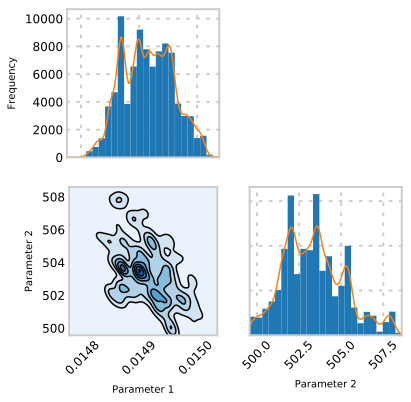

In [32]:
# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

## Effective sample size

- Ideally we would have independent samples from the posterior.
- Although in general independent sampling is not possible.
- Instead we use dependent sampling, where the next sample depends on the current value.
- Dependence $\Rightarrow$ less information per each additional sample.

## A definition of effective sample size

“The equivalent number of samples for an independent sampler”.

**Note:** the worth of an algorithm is the # effective samples per second not # samples per second!

## Measuring the cost of dependent sampling

- Create effective sample size (ESS) measure such that as dependence $\uparrow$ $\Rightarrow$ ESS $\downarrow$
- One way to measure dependence is by the autocorrelation of the sampler’s value.

$$ESS(\theta_i) = \frac{mT}{1 + 2 \sum_{\tau=1}^{\infty} \rho_\tau(\theta_i)}$$.

- Where $m$ is the number of chains, and $T$ is the number of samples per chain, and $\rho_\tau$ is the $\tau$th order autocorrelation for $\theta_i$.

In [33]:
pints.effective_sample_size(chains[0])

[79.66350233989073, 10.696177311044698]

## Adaptive Covariance MCMC

- Whole class of MCMC methods, with the aim to tune the step size $\sigma_0$ so that the ideal acceptance rate is achieved ($\sim 0.25$)
- For a $n$ dimensional parameter vector $\theta$, the jumping distribution $J$ is a multivariate normal with an $n \times n$ covariance matrix
- Adaptive algorithm presented in [1] uses the sample covariance of the previously accepted samples to set the covariance matrix of $J(\theta_i)$

$$\text{cov}(\theta_0, \theta_1, \theta_2, ..., \theta_i) = \frac{1}{i} \left ( \sum_{j=0}^i \theta_j \theta_j^T - (i+1)\bar{\theta}_i\bar{\theta}_i^T \right)$$

where $\bar{\theta}_i = (1/(i+1)) \sum_{j=0}^i \theta_j$


[1] *An adaptive Metropolis algorithm Heikki Haario, Eero Saksman, and Johanna Tamminen (2001) Bernoulli*

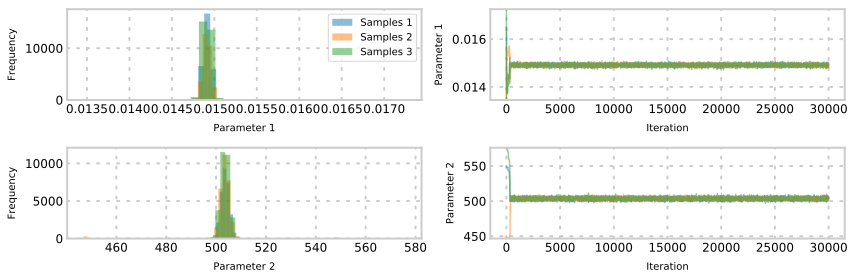

In [34]:
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)
mcmc.set_max_iterations(30000)
mcmc.set_log_to_screen(False)
chains = mcmc.run()
pints.plot.trace(chains)
plt.show()

## Result: significantly improved convergence

R-hat:
[1.000061879463885, 1.000279784982728]
ESS:
[1817.1609327397723, 1706.4594101992952]


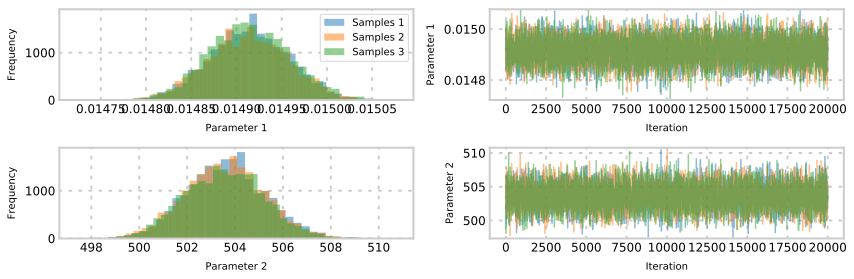

In [35]:
chains = chains[:, 10000:, :]
pints.plot.trace(chains)

print('R-hat:')
print(pints.rhat_all_params(chains))
print('ESS:')
print(pints.effective_sample_size(chains[0]))
plt.show()


## List of MCMC methods in PINTS

- See <https://pints.readthedocs.io/en/latest/mcmc_samplers/index.html>
 - Adaptive Covariance MCMC
 - Differential Evolution MCMC
 - DreamMCMC
 - EmceeHammerMCMC
 - Hamiltonian MCMC
 - Metropolis-Adjusted Langevin Algorithm (MALA) MCMC
 - Metropolis Random Walk MCMC
 - Population MCMC

## Summary
1. Sampling can be used to gain insight into a distribution.
2. Independent sampling from posterior not generally possible $\Rightarrow$ shift to dependent sampling.
3. Random Walk Metropolis is a MCMC algorithm that allows dependent sampling from the posterior.
4. The efficiency of Metropolis depends on choosing the right step size.
5. Monitoring of sampler’s convergence to the posterior is non-trivial.
6. The use of multiple chains makes it harder to make a mistake although not impossible.
7. We value # effective samples per second, not # samples.